In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from torch import autograd
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from pathlib import Path
from itertools import repeat
import tensorboardX
torch.cuda.set_device(0)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True


/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
uid = 'bw2color'
#keep_pct=0.02
keep_pct=1.0
#keep_pct=0.005
#keep_pct=1.0

In [4]:
def get_model_data(image_size: int, batch_size: int, keep_pct: float):
    TRAIN_X_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=True, size=image_size, uid=uid)
    TRAIN_Y_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=False, size=image_size, uid=uid)
    x_paths, y_paths = get_matched_xy_file_lists(TRAIN_X_PATH, TRAIN_Y_PATH)
    x_paths_str = convert_paths_to_str(x_paths)
    y_paths_str = convert_paths_to_str(y_paths)
    print(x_paths_str[:5])
    print(y_paths_str[:5])
    np.random.seed(42)
    keeps = np.random.rand(len(x_paths_str)) < keep_pct
    fnames_x = np.array(x_paths_str, copy=False)[keeps]
    fnames_y = np.array(y_paths_str, copy=False)[keeps]
    val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
    img_fn = TRAIN_Y_PATH/'n01558993'/'n01558993_9684.JPEG'
    tfms = tfms_from_stats(inception_stats, image_size, tfm_y=TfmType.PIXEL, aug_tfms=transforms_side_on, sz_y=image_size)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_Y_PATH.parent)
    md = ImageData(DATA_PATH, datasets, batch_size, num_workers=16, classes=None)
    return md

In [5]:
md = get_model_data(image_size=224, batch_size=128, keep_pct=keep_pct)
denorm = md.val_ds.denorm

['train_x_bw2color_224/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_224/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10042.JPEG']


In [6]:
def generate_denormed_image_pairs(ds: FilesDataset, batches: [(ndarray,ndarray)], idx:int = 0):
    return [(ds.denorm(x)[idx], ds.denorm(y)[idx])for (x,y) in batches]

## EDSR Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.
##### TODO:  Add tensorboard graphs

In [7]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [8]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def remove(self): 
        self.hook.remove()

In [9]:
class FeatureLoss(nn.Module):
    def __init__(self, block_wgts: [float] = [0.2,0.7,0.1]):
        super().__init__()
        m_vgg = vgg16(True)
        
        blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
        blocks, [m_vgg[i] for i in blocks]
        layer_ids = blocks[:3]
        
        vgg_layers = children(m_vgg)[:23]
        m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
        set_trainable(m_vgg, False)
        
        self.m,self.wgts = m_vgg,block_wgts
        self.sfs = [SaveFeatures(m_vgg[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(self.flatten(inp.features),self.flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def flatten(self, x): 
        return x.view(x.size(0), -1)
    
    def close(self):
        for o in self.sfs: o.remove()

In [10]:
def conv(ni, nf, kernel_size=3, actn=False, stride=1):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2, stride=stride)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [11]:
class UpSampleBlock(nn.Module):
    def __init__(self, ni, nf, scale=2):
        super().__init__()
        layers = []
        for i in range(int(math.log(scale,2))):
            layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
        self.sequence = nn.Sequential(*layers)
        self.icnr_init()
        
    def icnr_init(self):
        conv_shuffle = self.sequence[0][0]
        kernel = icnr(conv_shuffle.weight)
        conv_shuffle.weight.data.copy_(kernel);
    
    def forward(self, x):
        return self.sequence(x)

In [12]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [13]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)], 0.1)

In [14]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut

    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self, nf_up=32, nf_mid=64):
        super().__init__() 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        mid_layers = []
        mid_layers += [conv(128,nf_mid), nn.BatchNorm2d(nf_mid)]
        for i in range(8): mid_layers.append(res_block(nf_mid))
        mid_layers += [nn.BatchNorm2d(nf_mid), conv(nf_mid, 3, kernel_size=1)]
        self.upconv = nn.Sequential(*mid_layers)
             
        out_layers = []
        out_layers += [conv(6, 3, kernel_size=1)]
        self.out = nn.Sequential(*out_layers)
        
    def forward(self, x): 
        self.rn(x)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        x5 = self.upconv(torch.cat([x1, x2, x3, x4], dim=1))
        #x5 = self.upconv(torch.cat([x2, x3, x4], dim=1))
        return F.tanh(self.out(torch.cat([x, x5], dim=1)))

## WGAN Critic Model

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()   
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [16]:
class Critic(nn.Module):
    
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self, size, nf_up, nf_mid):
        super().__init__()
 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        self.raw_up = nn.Sequential(*[conv(3, nf_up)])
        
        mid_layers = []
        #mid_layers += [conv(nf_up*10,nf_mid), nn.BatchNorm2d(nf_mid)]
        mid_layers += [conv(nf_up*10,nf_mid)]
        for i in range(4): mid_layers.append(res_block(nf_mid))
        #mid_layers += [nn.BatchNorm2d(nf_mid), conv(nf_mid, nf_mid)]
        mid_layers += [conv(nf_mid, nf_mid)]
        self.upconv = nn.Sequential(*mid_layers)
        
        
        pyr_layers = []
        csize = size
        cndf = nf_mid
        
        while csize > 8:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2, bn=False))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        orig_features =  torch.cat([x1, x2, x3, x4], dim=1)
        
        self.rn(input)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        result_features = torch.cat([x1, x2, x3, x4], dim=1)
        
        orig_up = self.raw_up(orig)
        input_up = self.raw_up(orig)
        
        combined_features = torch.cat([orig_up, input_up, orig_features, result_features], dim=1)      
        x = self.upconv(combined_features)
        x = self.pyramid(x)
        return self.final(x).mean()

In [17]:
class Critic2(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
            
    def __init__(self, size, nf_up, nf_mid):
        super().__init__()
         
        self.nf_mid = nf_mid
        self.nf_up = nf_up
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(self.rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        self.raw_up = nn.Sequential(*[conv(3, nf_up)])
        
        self.mid = nn.Sequential(
            nn.Conv2d(nf_up*10, nf_mid, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(nf_mid, 2 * nf_mid, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * nf_mid, 4 * nf_mid, 3, 2, padding=1),
            nn.LeakyReLU(),
            Flatten()
        )


        self.out = nn.Sequential(
            nn.Linear(4*nf_mid*(size//(2**3))**2, 1))
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        orig_features =  torch.cat([x1, x2, x3, x4], dim=1)
        
        self.rn(input)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        result_features = torch.cat([x1, x2, x3, x4], dim=1)
        
        orig_up = self.raw_up(orig)
        input_up = self.raw_up(orig)
        
        combined_features = torch.cat([orig_up, input_up, orig_features, result_features], dim=1)      
        x = self.mid(combined_features)
        x = self.out(x)
        return x.mean()

## Training

In [18]:
#def train(lrs, session_num: int, cycle_len=2, use_clr_beta=(20,10,0.95,0.85)):
#    if session_num > 0:
#        learn.load(uid + '_224_' + str(session_num - 1))
#    learn.fit(lrs, 1, cycle_len=cycle_len, wds=wd, use_clr_beta=use_clr_beta)
#    learn.save(uid + '_224_' + str(session_num))

In [19]:
def visualize(md: ImageData, model: nn.Module, start_idx: int, count: int, figsize=(20,20), max_columns=4):
    end_index = start_idx + count
    idxs = list(range(start_idx,end_index))
    #plot_image_outputs_from_model(md.val_ds, model, list(range(start_idx,end_index)), figsize=figsize, max_columns=max_columns)
    
    image_pairs = []
    ds = md.val_ds

    for idx in idxs:
        x,_=ds[idx]
        preds = model(VV(x[None]))
        image_pairs.append((ds.denorm(x[None])[0], ds.denorm(preds)[0]))
        
    num_pairs = len(image_pairs)
    num_images = num_pairs * 2
    rows, columns = get_num_rows_columns(num_images, max_columns)

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    for i,(x,y) in enumerate(image_pairs):
        plot_image_from_ndarray(x, axes=axes.flat[i*2])
        plot_image_from_ndarray(y, axes=axes.flat[i*2+1])
        
    display(fig)

In [20]:
wd=1e-7
bs = 64
sz = 64
md = get_model_data(image_size=sz, batch_size=bs, keep_pct=keep_pct)
netG = ImageModifierModel().cuda()
netD = Critic2(size=sz, nf_up=64, nf_mid=128).cuda()

['train_x_bw2color_64/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_64/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10042.JPEG']


In [21]:
#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-4)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-4)

#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-3)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-3)

optimizerD = optim.Adam(filter(lambda p: p.requires_grad,netD.parameters()), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad,netG.parameters()), lr=1e-4, betas=(0.5, 0.9))

In [22]:
def calc_gradient_penalty(netD, real_data, fake_data, orig_data):
    lamda = 10 # Gradient penalty lambda hyperparameter
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(bs, 1)
    alpha = alpha.expand(bs, real_data.nelement()//bs).contiguous().view(bs, 3, sz, sz)
    alpha = alpha.cuda()
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates, orig_data)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamda
    return gradient_penalty

In [23]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                netD.set_trainable(True)
                netG.set_trainable(False)
                #d_iters = 1000 if (first and (gen_iterations < 500) or (gen_iterations % 100 == 0)) else 5
                #d_iters = 200 if (first and (gen_iterations < 50) or (gen_iterations % 1000 == 0)) else 10
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                #d_iters = 50 if (first and (gen_iterations < 12) or (gen_iterations % 250 == 0)) else 3
                #$d_iters = 20 if (first and (gen_iterations < 5) or (gen_iterations % 100 == 0)) else 1
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    #or p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    x, y = next(data_iter)
                    orig = V(x)
                    real = V(y)                        
                    #Lower == Real
                    real_loss = netD(real, orig)
                    fake = netG(orig)
                    fake_loss = netD(V(fake.data), orig)
                    netD.zero_grad()
                          
                    #train with gradient penalty
                    gradient_penalty = calc_gradient_penalty(netD, real.data, fake.data, orig)
                    gradient_penalty.backward()
                      
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                    
                netD.set_trainable(False)
                netG.set_trainable(True)
                netG.zero_grad()
                
                x, y = next(data_iter)
                orig = V(x)
                real = V(y)   
                fake = netG(orig)
                lossG = netD(fake, orig)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
                
                if i % 50 == 0:
                    print(f'\nWDist {to_np(lossD)}; Real Score {to_np(real_loss)}; Fake Score {to_np(fake_loss)}; Gen Loss{to_np(lossG)}')
                
                if i % 500 == 0:
                    visualize(md, netG, 500, 8)

In [24]:
torch.backends.cudnn.benchmark=True

  1%|          | 100/19819 [01:17<3:55:59,  1.39it/s]
WDist [-23756.656]; Real Score [3151.636]; Fake Score [26908.293]; Gen Loss[38188.6]
  1%|          | 200/19819 [02:34<3:55:34,  1.39it/s]
WDist [-87051.2]; Real Score [134248.5]; Fake Score [221299.7]; Gen Loss[240067.14]
  2%|▏         | 300/19819 [03:47<3:54:10,  1.39it/s]
WDist [-95919.34]; Real Score [136978.8]; Fake Score [232898.14]; Gen Loss[263488.9]
  2%|▏         | 400/19819 [05:03<3:53:28,  1.39it/s]
WDist [-79111.06]; Real Score [230388.31]; Fake Score [309499.38]; Gen Loss[272589.56]
  3%|▎         | 500/19819 [06:20<3:52:33,  1.38it/s]
WDist [-77417.84]; Real Score [263595.7]; Fake Score [341013.53]; Gen Loss[361041.44]


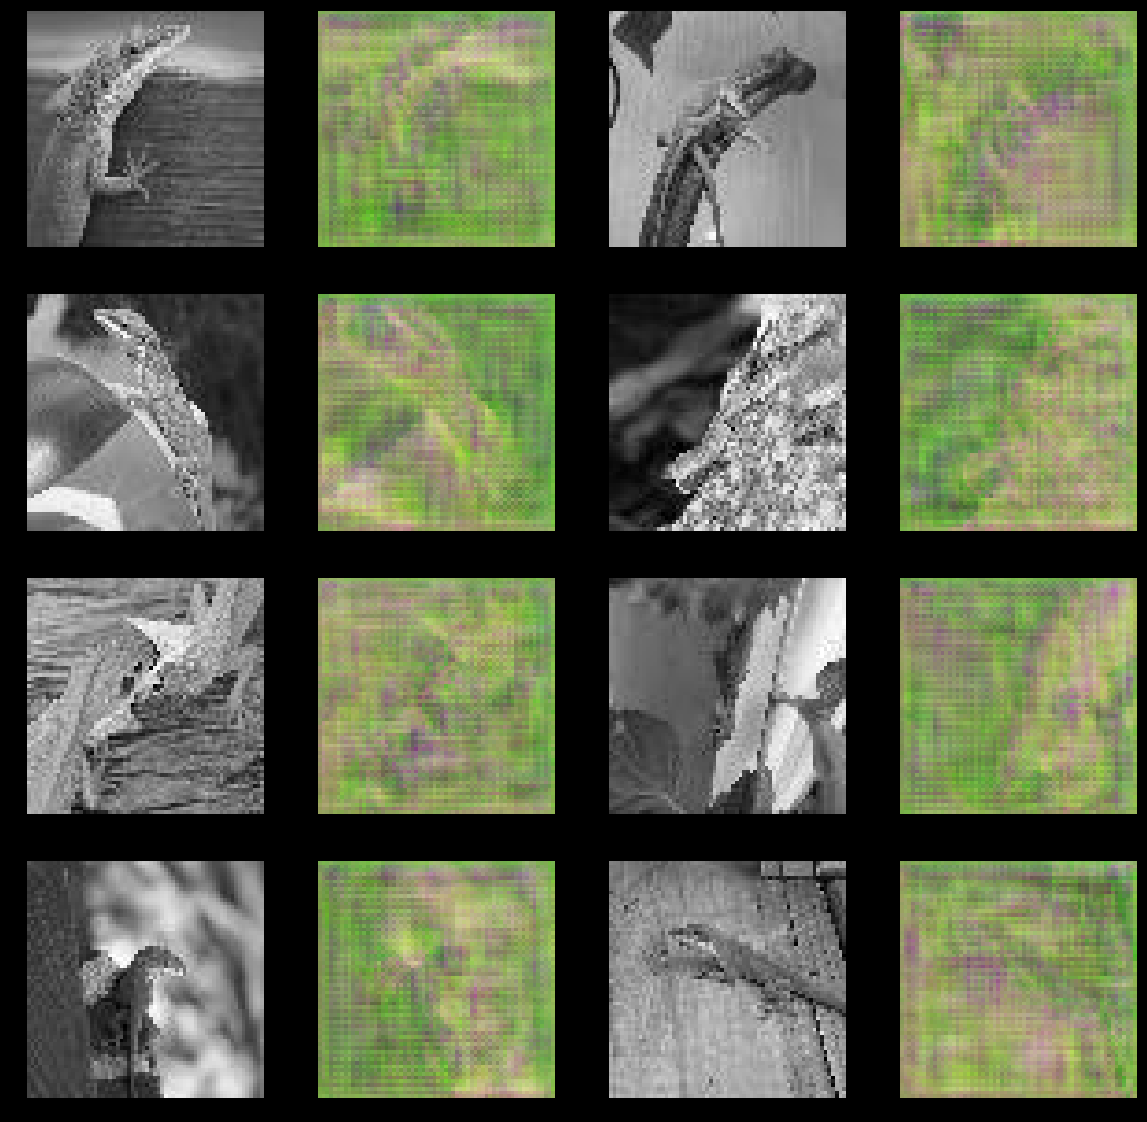

  3%|▎         | 600/19819 [07:34<3:51:15,  1.39it/s]
WDist [-80722.84]; Real Score [393786.03]; Fake Score [474508.88]; Gen Loss[525184.6]
  4%|▎         | 700/19819 [08:51<3:50:39,  1.38it/s]
WDist [-96860.81]; Real Score [713769.94]; Fake Score [810630.75]; Gen Loss[712016.4]
  4%|▍         | 800/19819 [10:08<4:38:02,  1.14it/s]
WDist [-110826.875]; Real Score [847360.44]; Fake Score [958187.3]; Gen Loss[879022.3]
  5%|▍         | 900/19819 [11:21<3:47:48,  1.38it/s]
WDist [-132319.38]; Real Score [1063700.]; Fake Score [1196019.4]; Gen Loss[1196553.1]
  5%|▌         | 1000/19819 [12:38<3:47:28,  1.38it/s]
WDist [-146430.12]; Real Score [1279560.1]; Fake Score [1425990.2]; Gen Loss[1372294.1]


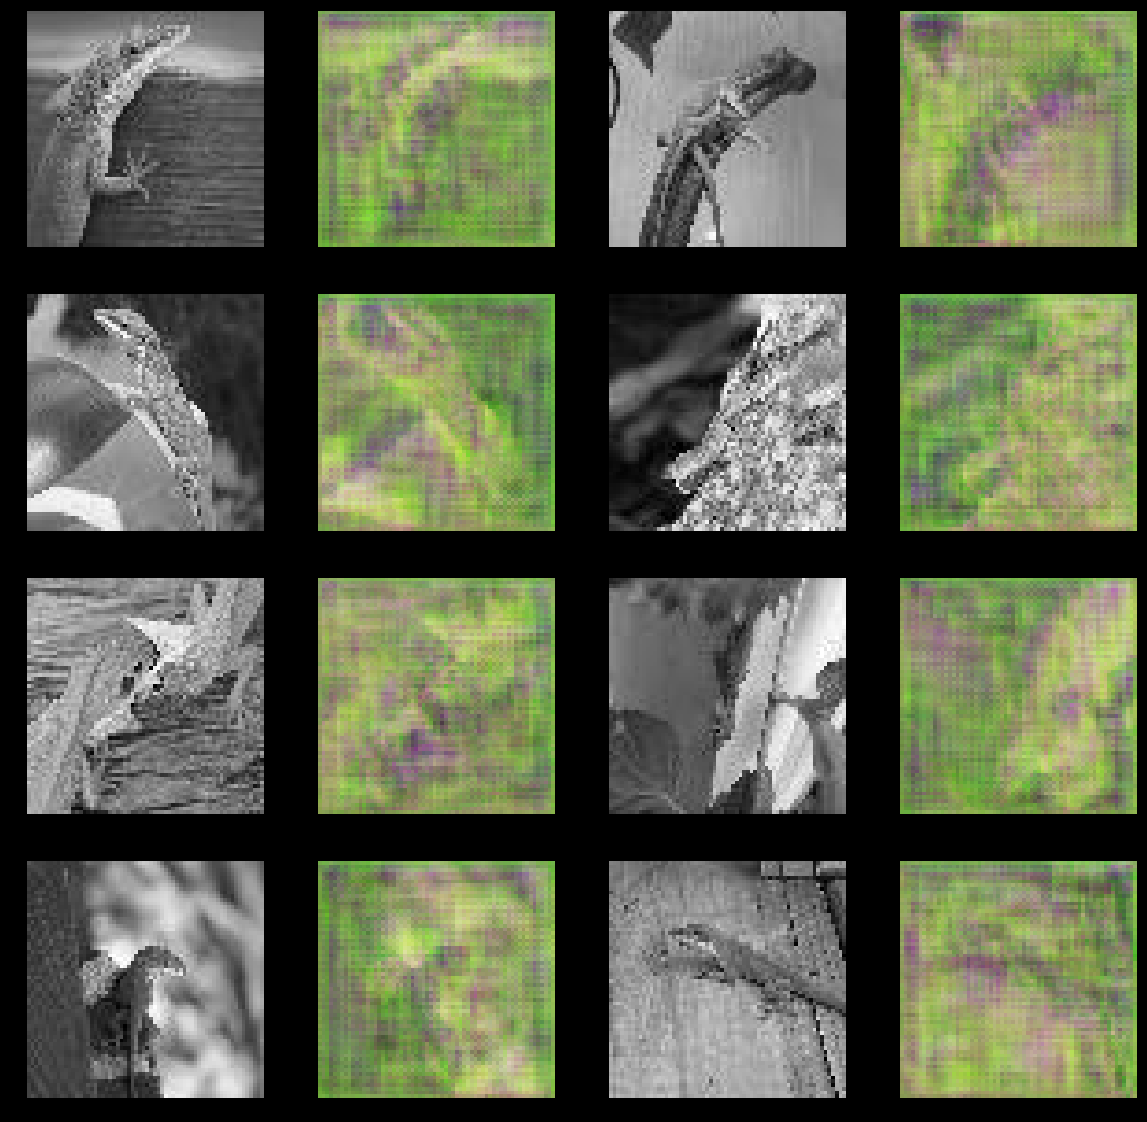

  6%|▌         | 1100/19819 [13:52<3:45:42,  1.38it/s]
WDist [-164253.88]; Real Score [1412301.8]; Fake Score [1576555.6]; Gen Loss[1596422.9]
  6%|▌         | 1200/19819 [15:09<3:44:27,  1.38it/s]
WDist [-159803.12]; Real Score [1872025.2]; Fake Score [2031828.4]; Gen Loss[1918231.4]
  7%|▋         | 1300/19819 [16:26<3:43:57,  1.38it/s]
WDist [-197845.5]; Real Score [2365998.]; Fake Score [2563843.5]; Gen Loss[2514705.]
  7%|▋         | 1400/19819 [17:39<3:42:25,  1.38it/s]
WDist [-185665.75]; Real Score [2745340.2]; Fake Score [2931006.]; Gen Loss[2965860.2]
  8%|▊         | 1500/19819 [18:55<3:40:46,  1.38it/s]
WDist [-185652.25]; Real Score [3102286.5]; Fake Score [3287938.8]; Gen Loss[3337816.5]


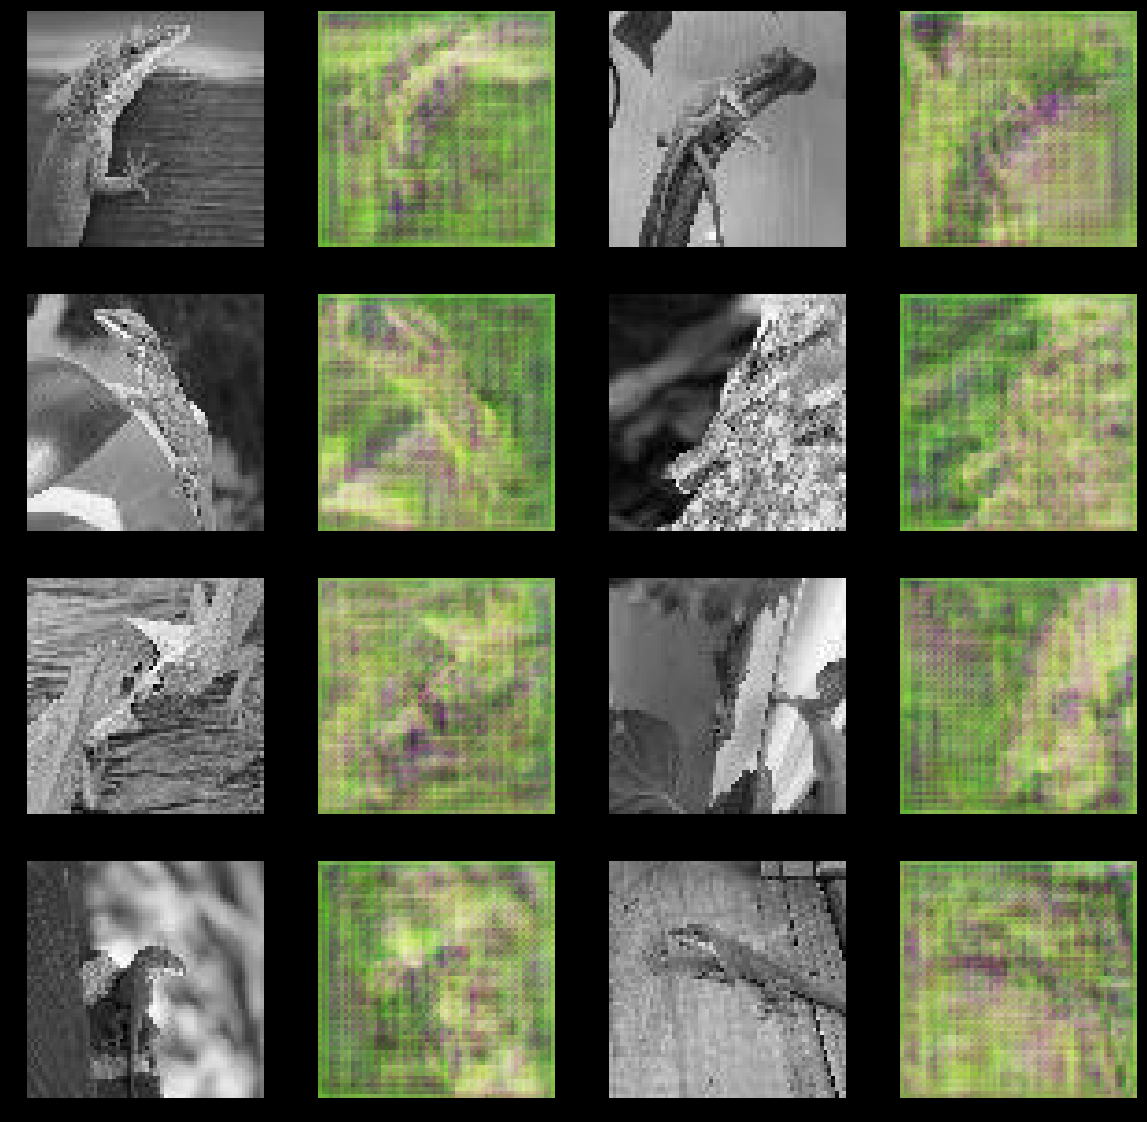

  8%|▊         | 1600/19819 [20:13<3:42:36,  1.36it/s]
WDist [-191238.75]; Real Score [3512061.5]; Fake Score [3703300.2]; Gen Loss[3749369.5]
  9%|▊         | 1700/19819 [21:26<3:38:03,  1.38it/s]
WDist [-186172.]; Real Score [3860552.]; Fake Score [4046724.]; Gen Loss[4038341.5]
  9%|▉         | 1800/19819 [22:43<3:37:50,  1.38it/s]
WDist [-210316.75]; Real Score [4142619.2]; Fake Score [4352936.]; Gen Loss[4416664.5]
 10%|▉         | 1900/19819 [23:56<3:36:00,  1.38it/s]
WDist [-200385.]; Real Score [4332423.5]; Fake Score [4532808.5]; Gen Loss[4603448.]
 10%|█         | 2000/19819 [25:13<3:34:56,  1.38it/s]
WDist [-191357.5]; Real Score [4550969.]; Fake Score [4742326.5]; Gen Loss[4814305.]


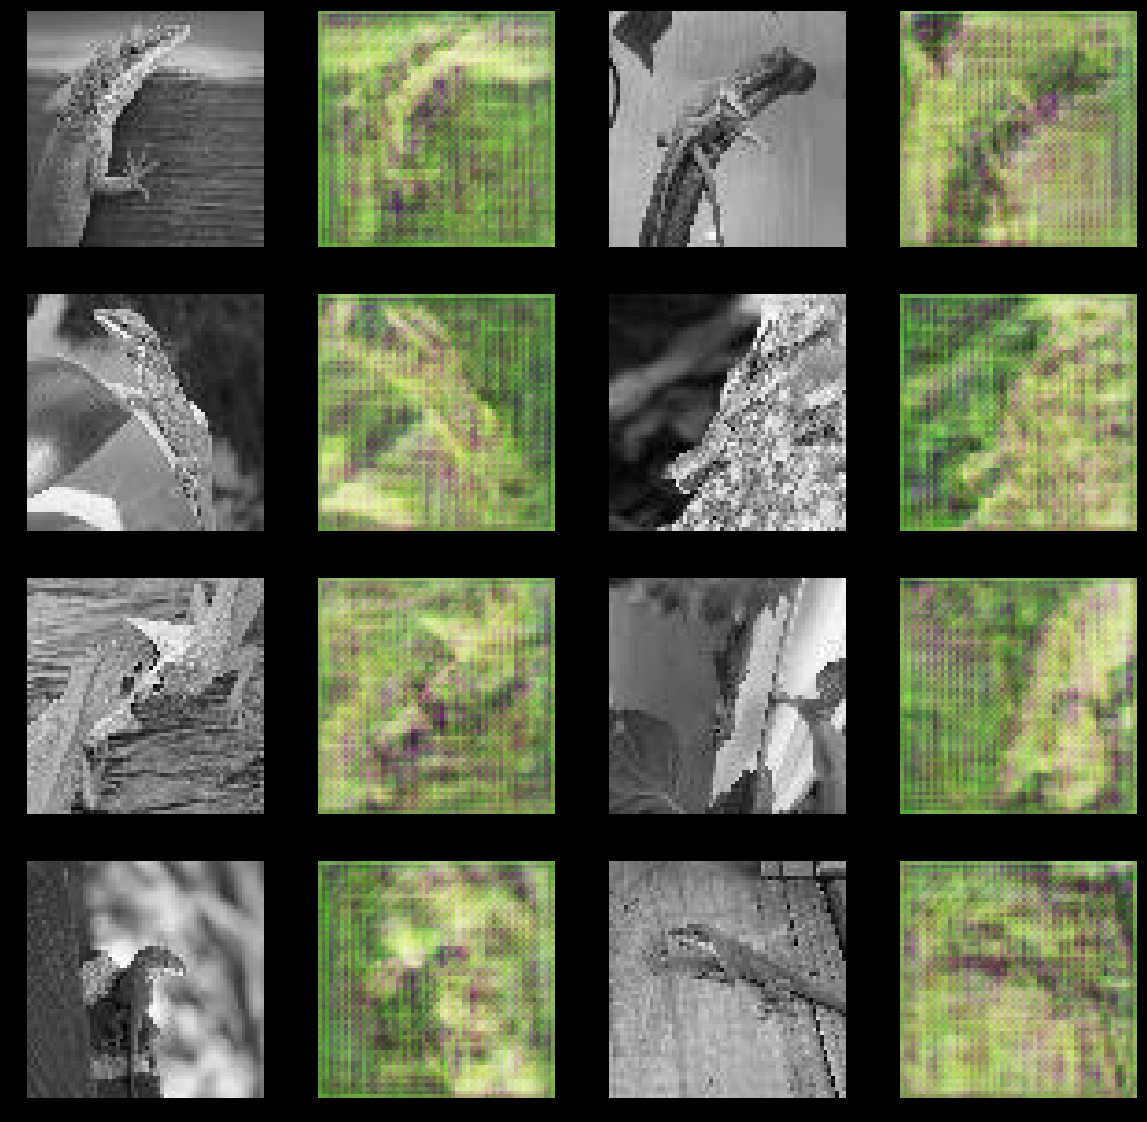

 11%|█         | 2100/19819 [26:30<3:34:21,  1.38it/s]
WDist [-188723.5]; Real Score [4708671.5]; Fake Score [4897395.]; Gen Loss[4846315.]
 11%|█         | 2200/19819 [27:43<3:32:32,  1.38it/s]
WDist [-205932.5]; Real Score [4969265.5]; Fake Score [5175198.]; Gen Loss[5152360.]
 12%|█▏        | 2300/19819 [29:00<3:31:15,  1.38it/s]
WDist [-198884.]; Real Score [4982682.]; Fake Score [5181566.]; Gen Loss[5119525.5]
 12%|█▏        | 2400/19819 [30:17<3:30:52,  1.38it/s]
WDist [-213515.]; Real Score [4751356.]; Fake Score [4964871.]; Gen Loss[5037127.5]
 13%|█▎        | 2500/19819 [31:30<3:28:47,  1.38it/s]
WDist [-229792.5]; Real Score [4810481.5]; Fake Score [5040274.]; Gen Loss[4929573.]


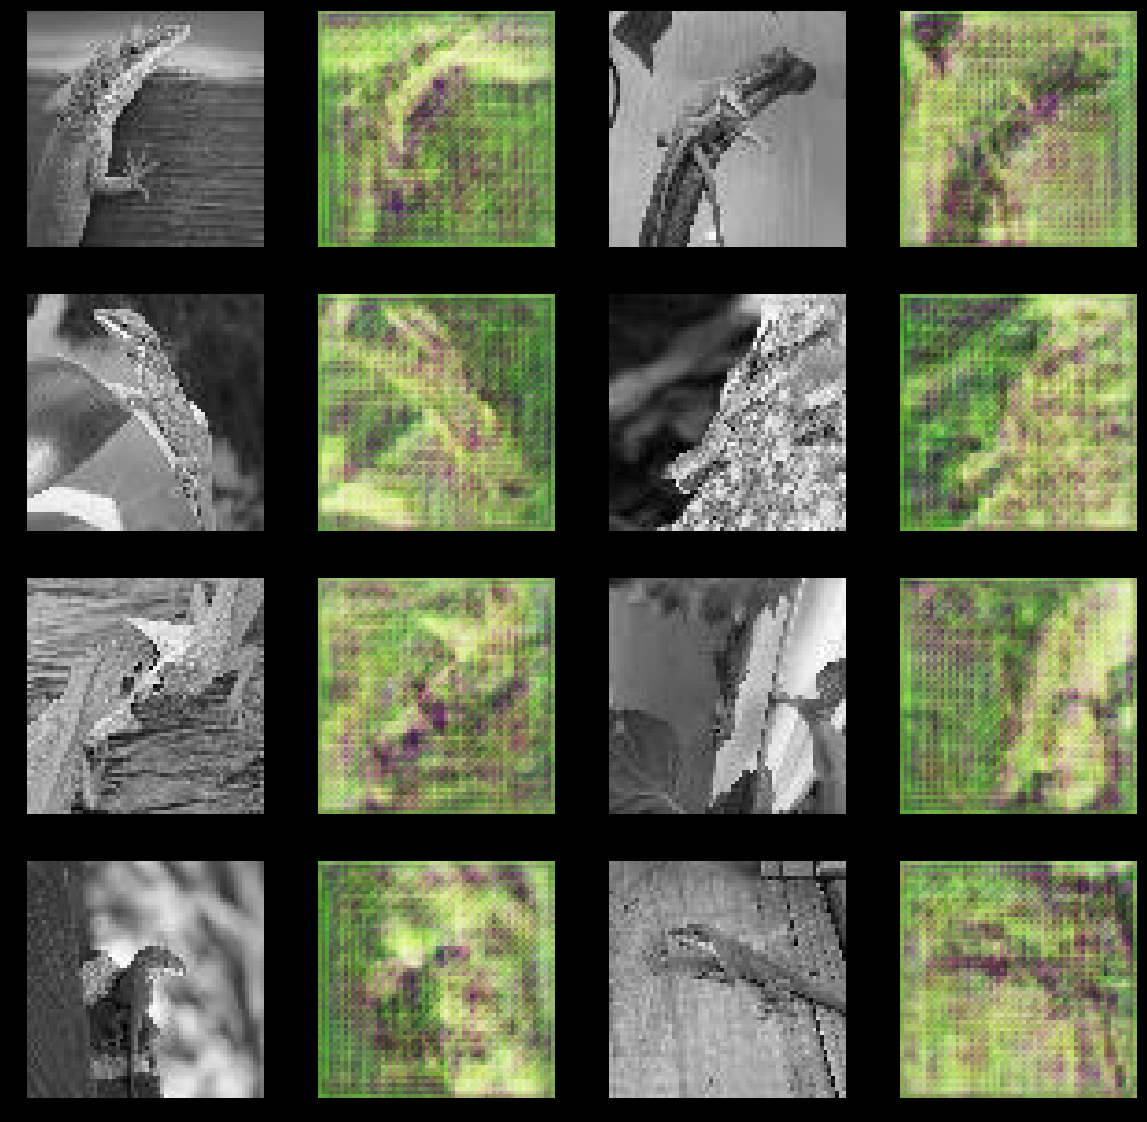

 13%|█▎        | 2550/19819 [32:13<3:36:05,  1.33it/s]
WDist [-131639.5]; Real Score [4764405.5]; Fake Score [4896045.]; Gen Loss[5014443.5]
 13%|█▎        | 2600/19819 [32:52<3:34:58,  1.33it/s]
WDist [-129843.5]; Real Score [4798968.5]; Fake Score [4928812.]; Gen Loss[4948922.5]
 13%|█▎        | 2650/19819 [33:31<3:33:46,  1.34it/s]
WDist [-124069.5]; Real Score [4735095.5]; Fake Score [4859165.]; Gen Loss[4813726.5]
 14%|█▎        | 2700/19819 [34:14<3:33:43,  1.33it/s]
WDist [-125488.5]; Real Score [4638787.5]; Fake Score [4764276.]; Gen Loss[4609648.5]
 14%|█▍        | 2750/19819 [34:53<3:32:38,  1.34it/s]
WDist [-120677.]; Real Score [4197174.]; Fake Score [4317851.]; Gen Loss[4401778.]
 14%|█▍        | 2800/19819 [35:36<5:38:39,  1.19s/it]
WDist [-95865.]; Real Score [4070613.]; Fake Score [4166478.]; Gen Loss[4110347.2]
 14%|█▍        | 2850/19819 [36:15<3:31:47,  1.34it/s]
WDist [-86782.5]; Real Score [3830029.5]; Fake Score [3916812.]; Gen Loss[3844138.2]
 15%|█▍        | 290

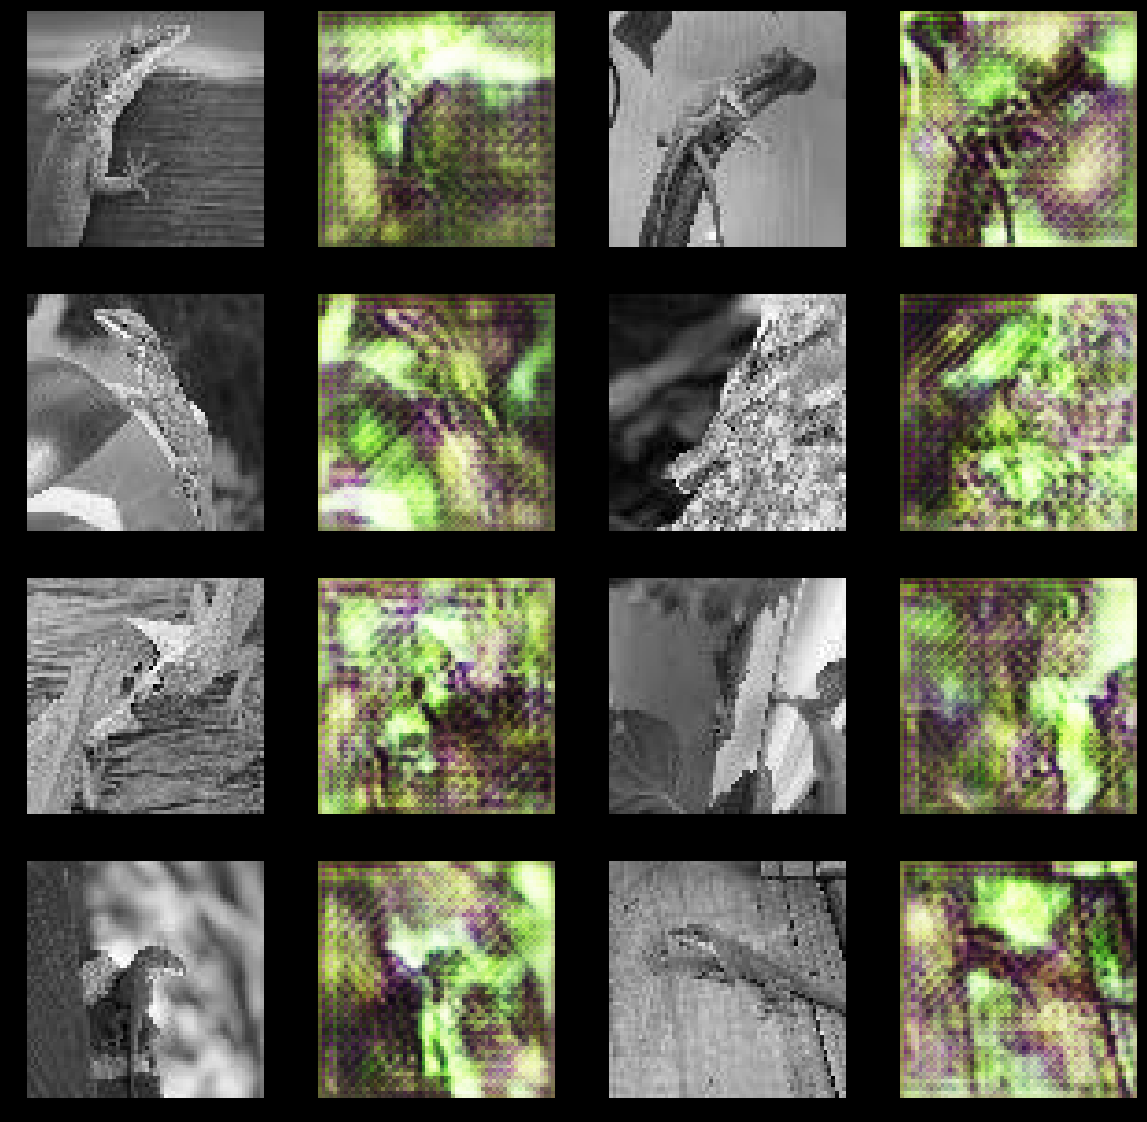

 15%|█▌        | 3050/19819 [38:56<3:28:35,  1.34it/s]
WDist [-70527.5]; Real Score [3655963.2]; Fake Score [3726490.8]; Gen Loss[3721796.5]
 16%|█▌        | 3100/19819 [39:39<3:29:09,  1.33it/s]
WDist [-69417.5]; Real Score [3466886.8]; Fake Score [3536304.2]; Gen Loss[3591840.5]
 16%|█▌        | 3150/19819 [40:18<3:27:58,  1.34it/s]
WDist [-66651.5]; Real Score [3314571.8]; Fake Score [3381223.2]; Gen Loss[3389425.2]
 16%|█▌        | 3200/19819 [41:01<5:30:45,  1.19s/it]
WDist [-58161.75]; Real Score [3058626.8]; Fake Score [3116788.5]; Gen Loss[3078846.5]
 16%|█▋        | 3250/19819 [41:40<3:26:45,  1.34it/s]
WDist [-60610.25]; Real Score [2793016.5]; Fake Score [2853626.8]; Gen Loss[2867151.5]
 17%|█▋        | 3300/19819 [42:19<3:25:47,  1.34it/s]
WDist [-53695.75]; Real Score [2428437.5]; Fake Score [2482133.2]; Gen Loss[2429618.2]
 17%|█▋        | 3350/19819 [43:02<3:26:20,  1.33it/s]
WDist [-59978.25]; Real Score [2187181.8]; Fake Score [2247160.]; Gen Loss[2235646.2]
 17%|█▋   

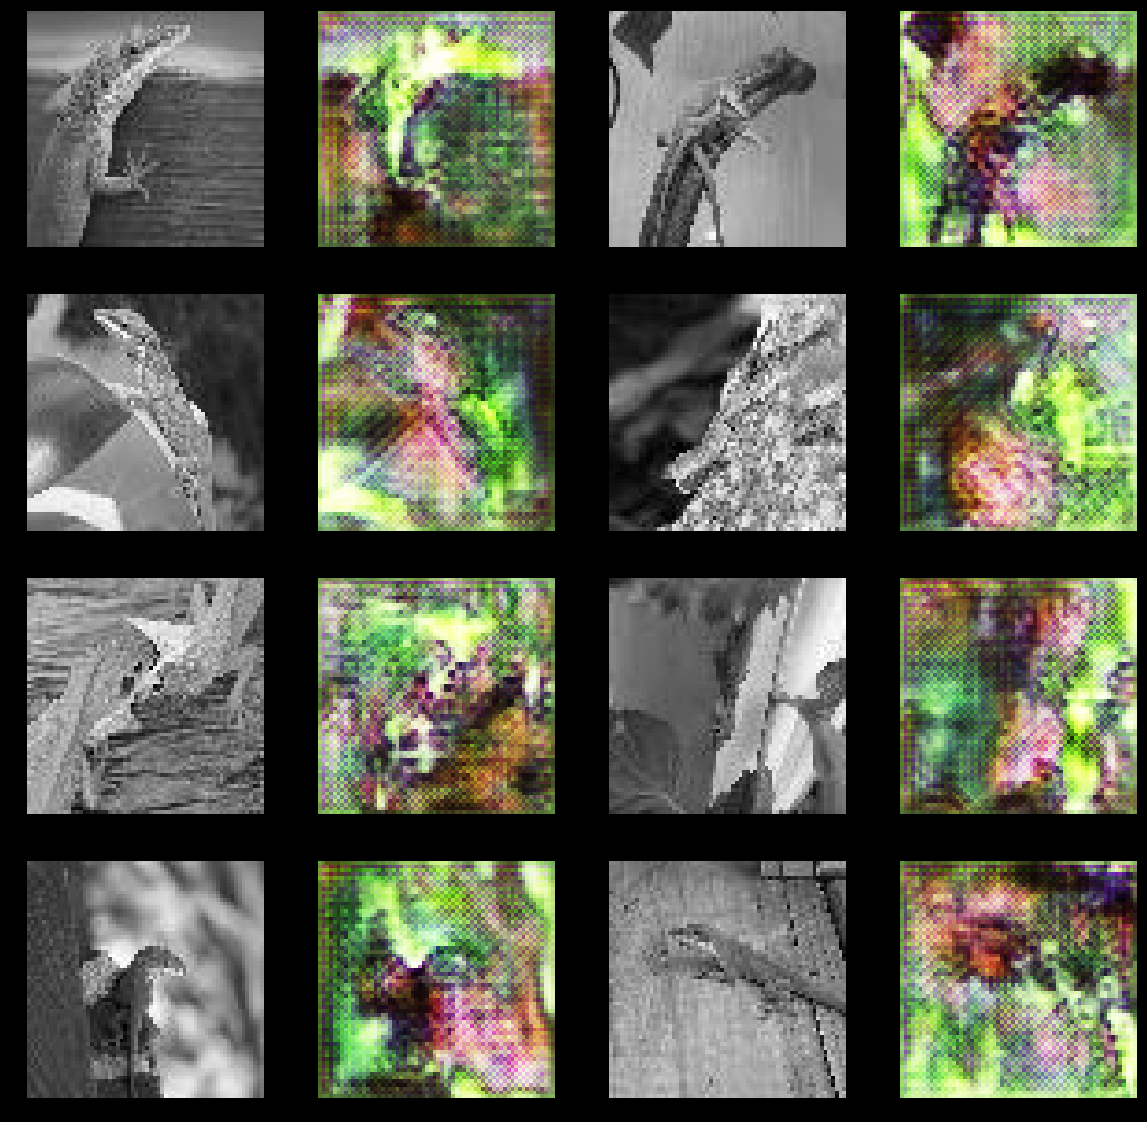

 18%|█▊        | 3550/19819 [45:43<3:23:04,  1.34it/s]
WDist [-52810.875]; Real Score [1670308.6]; Fake Score [1723119.5]; Gen Loss[1727867.]
 18%|█▊        | 3600/19819 [46:27<5:29:41,  1.22s/it]
WDist [-61398.375]; Real Score [1583902.9]; Fake Score [1645301.2]; Gen Loss[1652903.]
 18%|█▊        | 3650/19819 [47:06<3:21:44,  1.34it/s]
WDist [-59884.75]; Real Score [1575076.5]; Fake Score [1634961.2]; Gen Loss[1647278.6]
 19%|█▊        | 3700/19819 [47:45<3:21:24,  1.33it/s]
WDist [-49920.125]; Real Score [1536009.5]; Fake Score [1585929.6]; Gen Loss[1567655.6]
 19%|█▉        | 3750/19819 [48:28<3:21:00,  1.33it/s]
WDist [-46633.625]; Real Score [1398268.6]; Fake Score [1444902.2]; Gen Loss[1474392.9]
 19%|█▉        | 3800/19819 [49:07<3:19:44,  1.34it/s]
WDist [-56549.25]; Real Score [1356562.8]; Fake Score [1413112.]; Gen Loss[1375435.5]
 19%|█▉        | 3850/19819 [49:46<3:18:51,  1.34it/s]
WDist [-49497.375]; Real Score [1267785.6]; Fake Score [1317283.]; Gen Loss[1298151.4]
 20%|

In [ ]:
train(1, True)

In [ ]:
train(9, False)